In [78]:
from poke.thinfilms import compute_thin_films_broadcasted
from poke.poke_math import np, set_backend_to_jax
from poke.materials import create_index_model
set_backend_to_jax()
from jax import jacrev
import matplotlib.pyplot as plt

source module switched to  jax.numpy


# Designing Coatings for GMagAO-X
GMagAO-X has ~40 elements in their system, so high-throughput coatings are critical. Here we conduct a very preliminary design study to see if there are relatively simple coatings that will up the reflectivity from ~90% to 99%. According to [1], some materials commonly used in the VIS-SWIR for narrowband high-reflectors are: Ta2O5, TiO2, Nb2O5, LaTiO3.

I didn't find LaTiO3 on refractiveindex.info, but the rest have been included into poke.materials so that we can load them as splines.

References
----------
- [1] https://materion.com/-/media/files/advanced-materials-group/ac/ac-newsletter-article-pdfs/coating-materials-for-high-reflectors.pdf 

In [79]:
# refresher on poke's thin film calculation
# REMINDER that the last element of stack needs to be the substrate index. 
# Yes in addition to passing it the substrate. I just haven't gotten to it
help(compute_thin_films_broadcasted)

Help on function compute_thin_films_broadcasted in module poke.thinfilms:

compute_thin_films_broadcasted(stack, aoi, wavelength, ambient_index=1, substrate_index=1.5, polarization='s')
    compute fresnel coefficients for a multilayer stack using the BYU Optics Book method
    
    Parameters
    ----------
    stack : list of tuples containing raveled ndarrays, eg. [(n1,d1),(n2,d2),....] 
        The reciple that defines the multilayer stack. where n1.shape,d2.shape = aoi.shape
    aoi : numpy.ndarray
        angle of incidence on the thin film in radians
    wavelength : float
        wavelegnth of the light incident on the thin film stack. Should be in same units as thin film distances.
    ambient_index : float, optional
        index optical system is immersed in, by default 1
    substrate_index : float, optional
        index of substrate thin film is deposited on, by default 1.5
    polarization : str, optional
        polarization state to compute values for, can be 's' or 'p

In [80]:
wl = np.arange(0.5,1.8,0.01) # halpha ish

# try and generate some index models
n_Ag = create_index_model('Ag')
n_HfO2 = create_index_model('HfO2')
n_SiO2 = create_index_model('SiO2')
n_Ta2O5 = create_index_model('Ta2O5')
n_Nb2O5 = create_index_model('Nb2O5')

/opt/anaconda3/envs/gradfilms/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


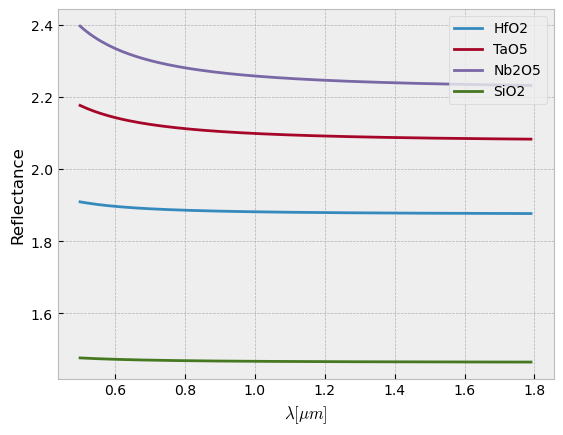

In [81]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure()
plt.plot(wl,n_HfO2(wl),label='HfO2')
plt.plot(wl,n_Ta2O5(wl),label='TaO5')
# plt.plot(wl,n_TiO2(wl),label='TiO2')
plt.plot(wl,n_Nb2O5(wl),label='Nb2O5')
plt.plot(wl,n_SiO2(wl),label='SiO2')
plt.xlabel(r'$\lambda [\mu m]$')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

In [82]:
# Try and optimize with Jax
aois = np.full_like(wl,10)
def evaluate_aoi_HfO2(a,aoi=aois):
    a = np.abs(a)
    stack = [
        (n_HfO2(wl),np.full_like(wl,a[0])),
        (n_SiO2(wl),np.full_like(wl,a[1])),
        (n_Ag(wl))
    ]

    # compute the complex amplitude coefficients
    rs,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wl,substrate_index=n_Ag(wl))
    rp,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wl,substrate_index=n_Ag(wl),polarization='p')

    return rs,rp

def evaluate_aoi_Ta2O5(a,aoi=aois):
    a = np.abs(a)
    stack = [
        (n_Ta2O5(wl),np.full_like(wl,a[0])),
        (n_SiO2(wl),np.full_like(wl,a[1])),
        (n_Ag(wl))
    ]

    # compute the complex amplitude coefficients
    rs,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wl,substrate_index=n_Ag(wl))
    rp,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wl,substrate_index=n_Ag(wl),polarization='p')

    return rs,rp

def evaluate_aoi_Nb2O5(a,aoi=aois):
    a = np.abs(a)
    stack = [
        (n_Nb2O5(wl),np.full_like(wl,a[0])),
        (n_SiO2(wl),np.full_like(wl,a[1])),
        (n_Ag(wl))
    ]

    # compute the complex amplitude coefficients
    rs,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wl,substrate_index=n_Ag(wl))
    rp,_ = compute_thin_films_broadcasted(stack,np.radians(aoi),wl,substrate_index=n_Ag(wl),polarization='p')

    return rs,rp

def optimize_aoi(a,eval_function):
    """objective function

    Parameters
    ----------
    a : numpy.ndarray
        vector of film thicknesses
    """
    scale_reflectivity = 1
    scale_regularization = 1

    # rs,rp = evaluate_aoi_Ta2O5(a)
    rs,rp = eval_function(a)

    # cost function
    R = (np.abs(rs)**2 + np.abs(rp)**2) / 2 # has shape of AOI
    cost = 0
    for i,w in enumerate(wl[:-1]):

        # max reflectivity
        cost += -np.sum((R[i])**2 / rs.size) * scale_reflectivity

        # regularization
        cost += np.sum(np.abs(R[i]-R[i+1])**2) / rs.size * scale_regularization

    return cost

In [84]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from jax import value_and_grad

valgrad_coating_optimizer = value_and_grad(optimize_aoi)

# start with some thicknesses
# It might be good to sort of basin hop? Like start with a few wavelengths and optimize them all, compare the results
a0 = np.full(4,0.656/4)
# results = minimize(valgrad_coating_optimizer,x0=a0,method='L-BFGS-B',jac=True,args=())
# print(results.message)

In [86]:
# results_Ta = minimize(valgrad_coating_optimizer,x0=a0,method='L-BFGS-B',jac=True,args=(evaluate_aoi_Ta2O5))
# print(results_Ta.message)
# print(f'total_thickness Ta2O5 recipe = {np.sum(np.abs(results_Ta.x))}')
# rs_Ta,rp_Ta = evaluate_aoi_Ta2O5(results_Ta.x)
# R_Ta = (np.abs(rs_Ta)**2 + np.abs(rp_Ta)**2) / 2

results_Hf = basinhopping(valgrad_coating_optimizer,x0=a0,
                          minimizer_kwargs={
                            'method':'L-BFGS-B',
                            'jac':True,
                            'args':(evaluate_aoi_HfO2)
                            })
print(results_Hf.message)
print(f'total_thickness HfO2 recipe = {np.sum(np.abs(results_Hf.x))}')
rs_Hf,rp_Hf = evaluate_aoi_HfO2(results_Hf.x)
R_Hf = (np.abs(rs_Hf)**2 + np.abs(rp_Hf)**2) / 2

# results_Nb = minimize(valgrad_coating_optimizer,x0=a0,method='L-BFGS-B',jac=True,args=(evaluate_aoi_Nb2O5))
# print(results_Nb.message)
# rs_Nb,rp_Nb = evaluate_aoi_Nb2O5(results_Nb.x)
# print(f'total_thickness Nb2O5 recipe = {np.sum(np.abs(results_Nb.x))}')
# R_Nb = (np.abs(rs_Nb)**2 + np.abs(rp_Nb)**2) / 2


['requested number of basinhopping iterations completed successfully']
total_thickness HfO2 recipe = 0.6438528924088893


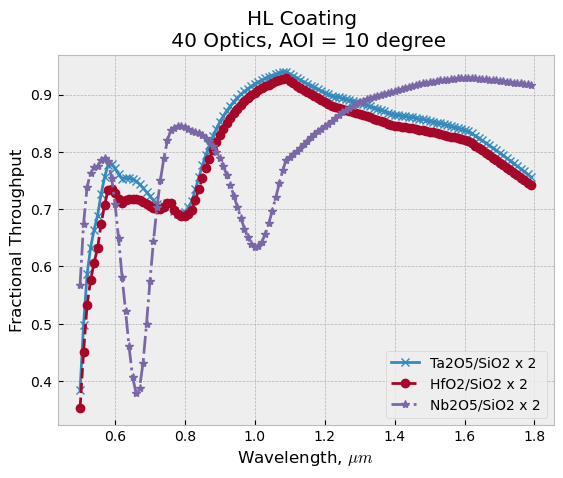

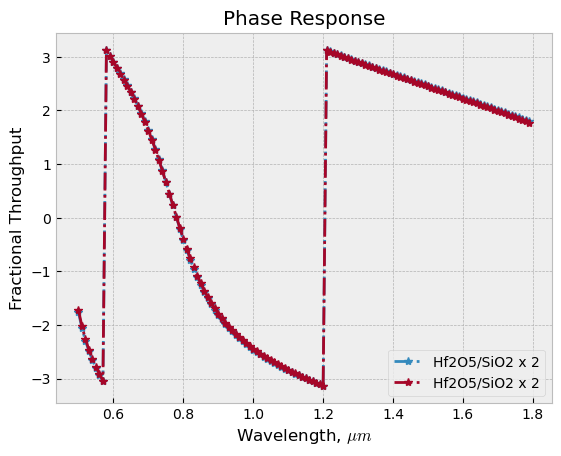

In [36]:
noptics = 40
plt.figure()
plt.title(f'HL Coating \n {noptics} Optics, AOI = 10 degree')
plt.plot(wl,R_Ta**noptics,label='Ta2O5/SiO2 x 2',linestyle='solid',marker='x')
plt.plot(wl,R_Hf**noptics,label='HfO2/SiO2 x 2',linestyle='dashed',marker='o')
plt.plot(wl,R_Nb**noptics,label='Nb2O5/SiO2 x 2',linestyle='dashdot',marker='*')
plt.ylabel('Fractional Throughput')
plt.xlabel('Wavelength, '+r'$\mu m$')
plt.legend()
plt.show()

plt.figure()
plt.title(f'Phase Response')
# plt.plot(wl,np.angle(rs_Ta),label='Ta2O5/SiO2 x 2',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rp_Ta),label='Ta2O5/SiO2 x 2',linestyle='dashdot',marker='*')
plt.plot(wl,np.angle(rs_Hf),label='Hf2O5/SiO2 x 2',linestyle='dashdot',marker='*')
plt.plot(wl,np.angle(rp_Hf),label='Hf2O5/SiO2 x 2',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rs_Nb),label='Nb2O5/SiO2 x 2',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rp_Nb),label='Nb2O5/SiO2 x 2',linestyle='dashdot',marker='*')
plt.ylabel('Fractional Throughput')
plt.xlabel('Wavelength, '+r'$\mu m$')
plt.legend()
plt.show()

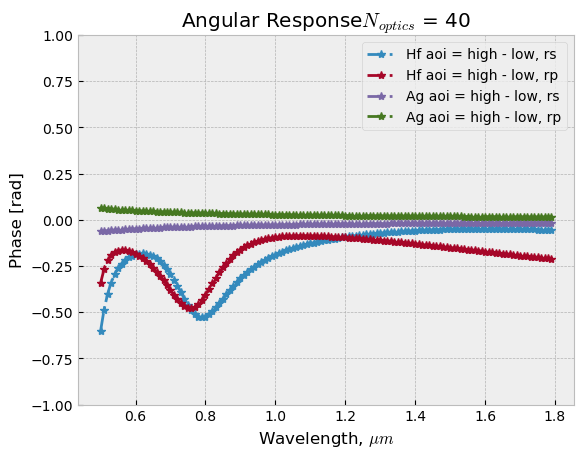

HfO2 : 0.21259262755772734um
SiO2 : 0.10326026485116195um
HfO2 : 0.164um
SiO2 : 0.164um


In [77]:
from poke.polarization import fresnel_coefficients
noptics = 40
cen = 10
pm = .4

# logic
low = cen - pm
high = cen + pm

# how does it hold up for more aoi?
aoi_low = np.full_like(wl,low)
aoi_cen = np.full_like(wl,cen)
aoi_high = np.full_like(wl,high)

# try look at HfO2
rs_low,rp_low = evaluate_aoi_HfO2(results_Hf.x,aoi=aoi_low)
R_low = (np.abs(rs_low)**2 + np.abs(rp_low)**2) / 2
rs_cen,rp_cen = evaluate_aoi_HfO2(results_Hf.x,aoi=aoi_cen)
R_cen = (np.abs(rs_cen)**2 + np.abs(rp_cen)**2) / 2
rs_high,rp_high = evaluate_aoi_HfO2(results_Hf.x,aoi=aoi_high)
R_high = (np.abs(rs_high)**2 + np.abs(rp_high)**2) / 2

# now do the same, bare silver, defaults to reflect
rs_ag_low,rp_ag_low = fresnel_coefficients(np.radians(low),1,n_Ag(wl))
rs_ag_cen,rp_ag_cen = fresnel_coefficients(np.radians(cen),1,n_Ag(wl))
rs_ag_high,rp_ag_high = fresnel_coefficients(np.radians(high),1,n_Ag(wl))

plt.figure()
plt.title(f'Angular Response'+r'$N_{optics}$ = '+f'{noptics}')
# plt.plot(wl,R_5**noptics,label='Hf aoi = 5',linestyle='dashdot',marker='*')
# plt.plot(wl,R_10**noptics,label='Hf aoi = 10',linestyle='dashdot',marker='*')
# plt.plot(wl,R_15**noptics,label='Hf aoi = 15',linestyle='dashdot',marker='*')
plt.plot(wl,noptics*(np.angle(rs_high)-np.angle(rs_low)),label='Hf aoi = high - low, rs',linestyle='dashdot',marker='*')
plt.plot(wl,noptics*(np.angle(rp_high)-np.angle(rp_low)),label='Hf aoi = high - low, rp',linestyle='dashdot',marker='*')
plt.plot(wl,noptics*(np.angle(rs_ag_high)-np.angle(rs_ag_low)),label='Ag aoi = high - low, rs',linestyle='dashdot',marker='*')
plt.plot(wl,noptics*(np.angle(rp_ag_high)-np.angle(rp_ag_low)),label='Ag aoi = high - low, rp',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rs_10),label='Hf aoi = 10, rs',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rp_10),label='Hf aoi = 10, rp',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rs_15),label='Hf aoi = 15, rs',linestyle='dashdot',marker='*')
# plt.plot(wl,np.angle(rp_15),label='Hf aoi = 15, rp',linestyle='dashdot',marker='*')
plt.ylabel('Phase [rad]')
plt.xlabel('Wavelength, '+r'$\mu m$')
plt.legend()
plt.ylim(-1,1)
plt.show()
for i,layer in enumerate(results_Hf.x):
    if i%2 == 0:
        print('HfO2 : '+str(layer)+'um')
    else:
        print('SiO2 : '+str(layer)+'um')


In [57]:
help(fresnel_coefficients)

Help on function fresnel_coefficients in module poke.polarization:

fresnel_coefficients(aoi, n1, n2, mode='reflect')
    Computes Fresnel Coefficients for a single surface interaction
    
    Parameters
    ----------
    aoi : float or array of floats
        angle of incidence in radians on the interface
    n1 : float 
        complex refractive index of the incident media
    n2 : float
        complex refractive index of the exitant media
    
    Returns
    -------
    fs, fp: complex floats
        the Fresnel s- and p- coefficients of the surface interaction

